In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")
import os
import pathlib

inputdir = "/Volumes/HNWD02/outdir/output_methyl_ReadBased_Models/01_output/TSMA_panel"
path_to_all_fa = "/Volumes/HNSD01/storage/ref/hg19"
outdir = "/Volumes/HNSD01/outdir"
outputdir = os.path.join(outdir, "output_methyl_ReadBased_Models")
path_to_01_output = os.path.join(outputdir, "01_output")
path_to_02_output = os.path.join(outputdir, "02_output")
path_to_03_output = os.path.join(outputdir, "03_output")
os.system(f"mkdir -p {path_to_03_output}")

region = "1_121261113_121261188"

df = pd.read_csv(os.path.join(path_to_02_output, f"{region}_methylString.csv"), index_col = [0])
cpg_coords = [item for item in df.columns if item not in 
["methyl_string", "SampleID","cover","LABCODE","TYPE"] ]

df = df[df["cover"] == df["cover"].max()]

# Filter rows where all cpg_coord columns are either 0 or 1
maskdf = pd.DataFrame()
for c in cpg_coords:
    maskdf[c] = [df[df[c].isin([0,1])].shape[0]]
maskdf = maskdf.T.reset_index()
full_cover_cpgs = maskdf[maskdf[0] == df.shape[0]]["index"].tolist()
df = df[full_cover_cpgs + ["methyl_string", "SampleID","cover","LABCODE","TYPE"]]
df["full_cover_methyl_string"] = df[full_cover_cpgs].astype(str).agg(''.join, axis=1)

In [2]:
tsmadf = pd.read_excel("/Users/hieunguyen/src/tsma_micro_atlas/assets/12967_2024_5416_MOESM1_ESM.xlsx")
tsmadf[tsmadf["Region_name"] == region]

,Region_name,Group,chromosome,coord.Start,coord.End,symbol
1050,1_121261113_121261188,Liver,1,121261113,121261188,EMBP1


In [3]:
tsmadf[tsmadf["Group"] == "Liver"]

,Region_name,Group,chromosome,coord.Start,coord.End,symbol
1050,1_121261113_121261188,Liver,1,121261113,121261188,EMBP1
1051,1_121261317_121261404,Liver,1,121261317,121261404,EMBP1
1052,1_13348765_13348821,Liver,1,13348765,13348821,NaN
1053,1_13839654_13839728,Liver,1,13839654,13839728,LRRC38
1054,1_148854695_148854780,Liver,1,148854695,148854780,NaN
...,...,...,...,...,...,...
1591,9_69178940_69179010,Liver,9,69178940,69179010,LINC03025
1592,9_69899978_69900043,Liver,9,69899978,69900043,NaN
1593,9_77113505_77113582,Liver,9,77113505,77113582,RORB
1594,9_77114241_77114342,Liver,9,77114241,77114342,RORB


<Axes: xlabel='SampleID', ylabel='full_cover_methyl_string'>

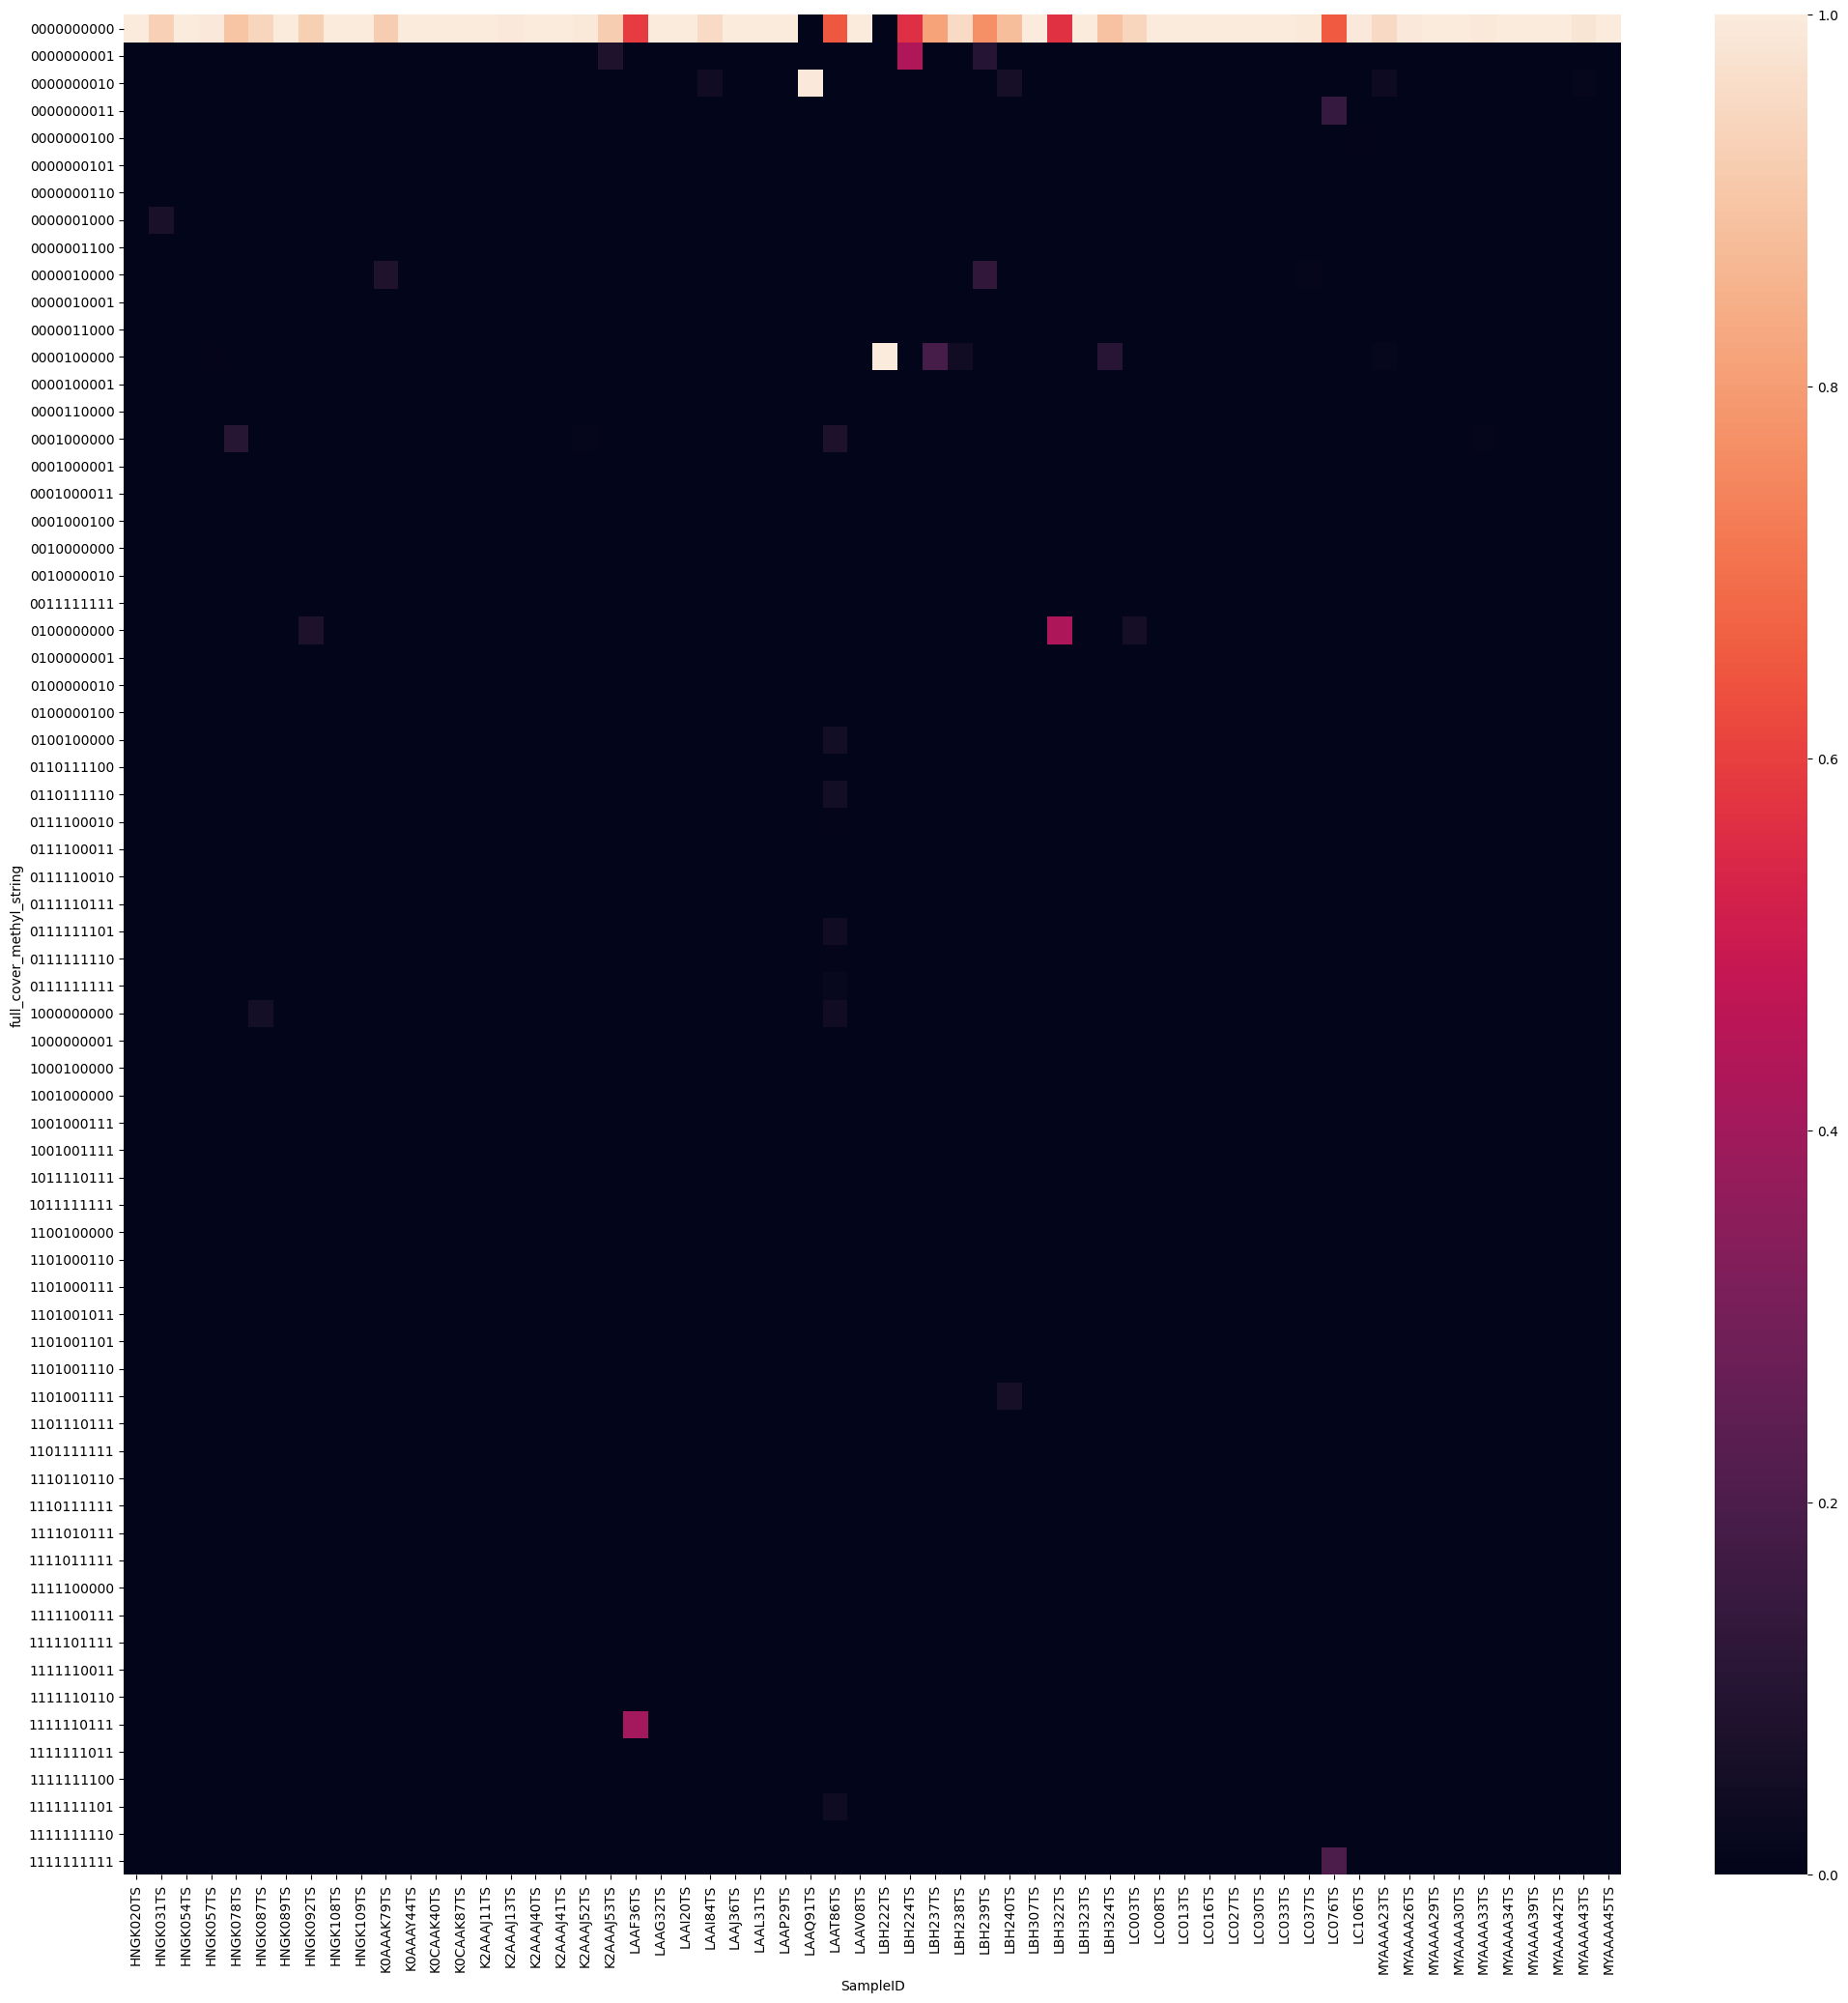

In [4]:
dfcount = df.groupby(["SampleID", "full_cover_methyl_string"])["TYPE"].count().reset_index()
dfcount_wide = dfcount.pivot(index='full_cover_methyl_string', columns='SampleID', values='TYPE').fillna(0)
for n in dfcount_wide.columns:
    dfcount_wide[n] = dfcount_wide[n]/dfcount_wide[n].sum()

plt.figure(figsize=(25,25))
sns.heatmap(dfcount_wide)

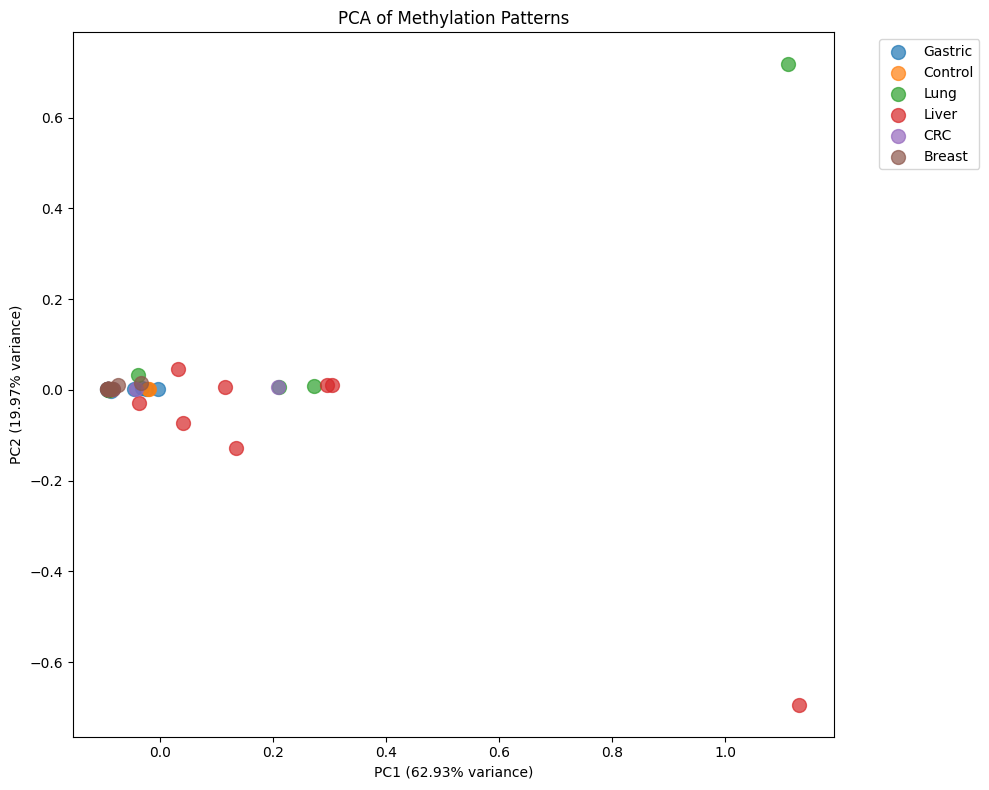

In [5]:
from sklearn.decomposition import PCA

# First, we need to extract sample metadata from df
# Get unique sample information (SampleID and TYPE)
metadata = df[['SampleID', 'TYPE']].drop_duplicates().set_index('SampleID')

# Perform PCA

# Transpose dfcount_wide so samples are rows
dfcount_wide_T = dfcount_wide.T

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfcount_wide_T)

# Create a dataframe with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=dfcount_wide_T.index)

# Add TYPE information from metadata
pca_df['TYPE'] = pca_df.index.map(metadata['TYPE'])

# Plot PCA
plt.figure(figsize=(10, 8))
for tissue_type in pca_df['TYPE'].unique():
    subset = pca_df[pca_df['TYPE'] == tissue_type]
    plt.scatter(subset['PC1'], subset['PC2'], label=tissue_type, s=100, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Methylation Patterns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: xlabel='SampleID', ylabel='full_cover_methyl_string'>

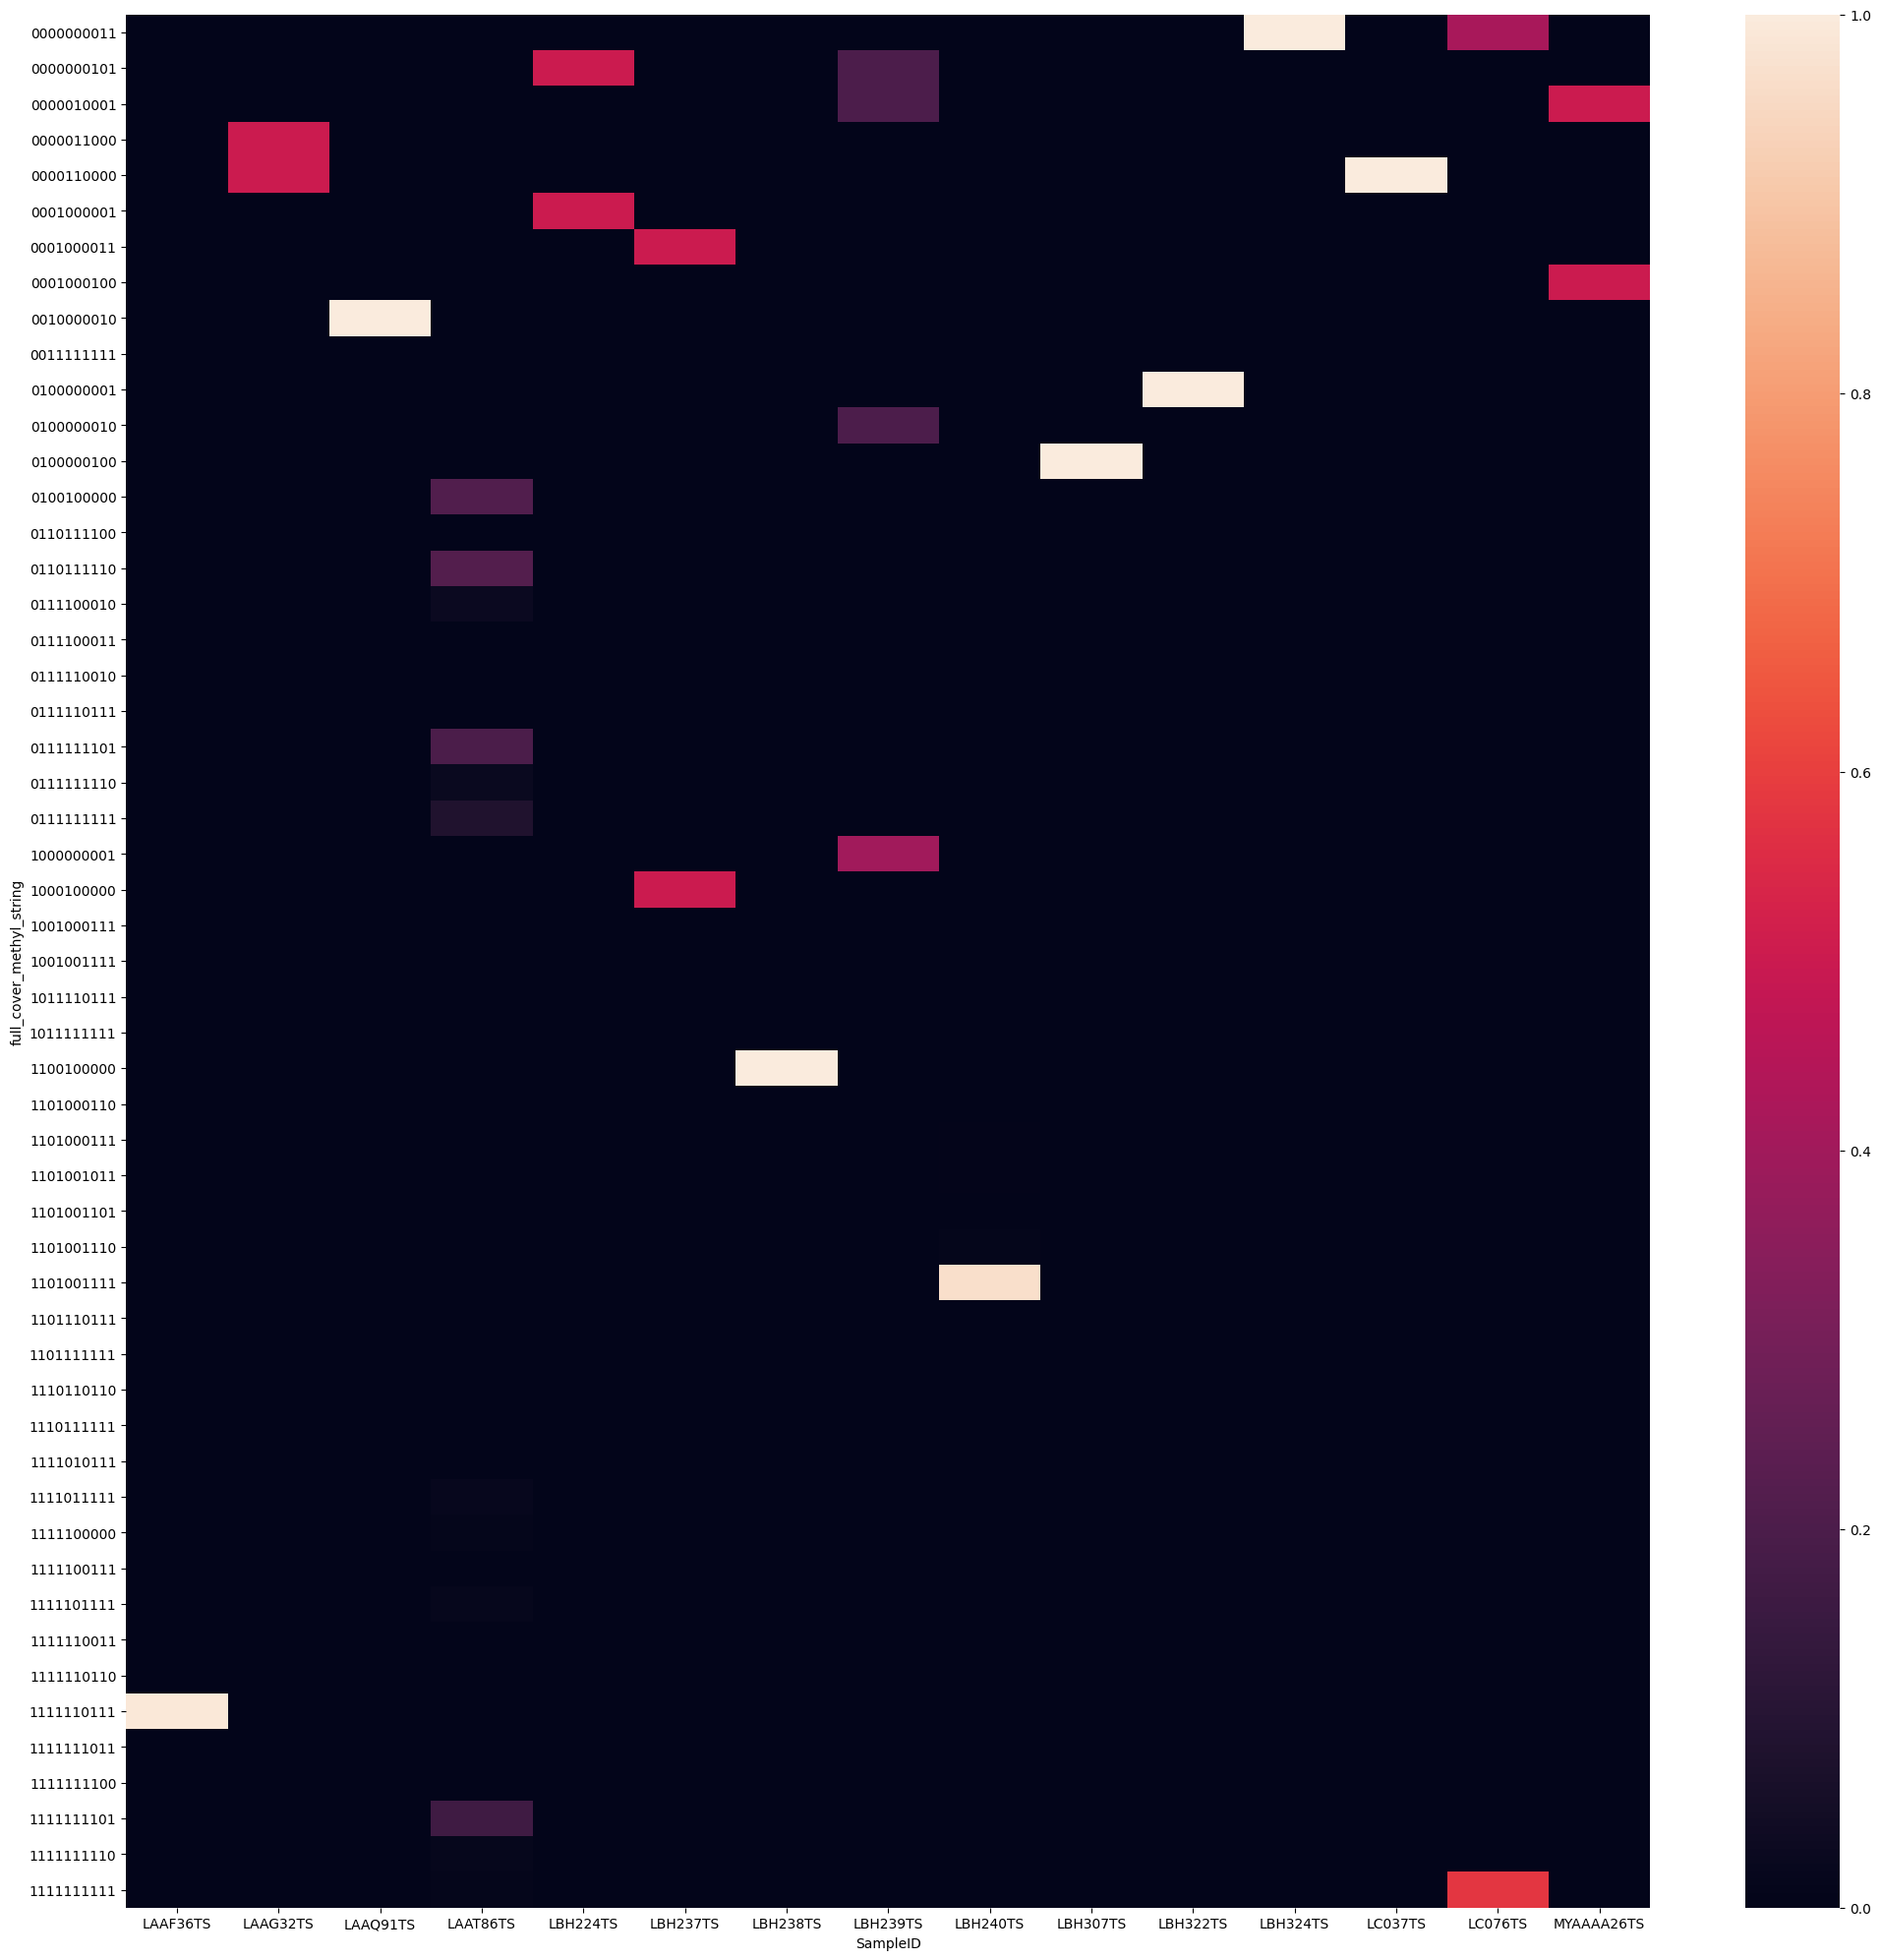

In [6]:
wbc_patterns = df[df["TYPE"] == "Control"].full_cover_methyl_string.unique()

df_nowbc = df[df["full_cover_methyl_string"].isin(wbc_patterns) == False]


dfcount = df_nowbc.groupby(["SampleID", "full_cover_methyl_string"])["TYPE"].count().reset_index()
dfcount_wide = dfcount.pivot(index='full_cover_methyl_string', columns='SampleID', values='TYPE').fillna(0)
for n in dfcount_wide.columns:
    dfcount_wide[n] = dfcount_wide[n]/dfcount_wide[n].sum()

plt.figure(figsize=(25,25))
sns.heatmap(dfcount_wide)

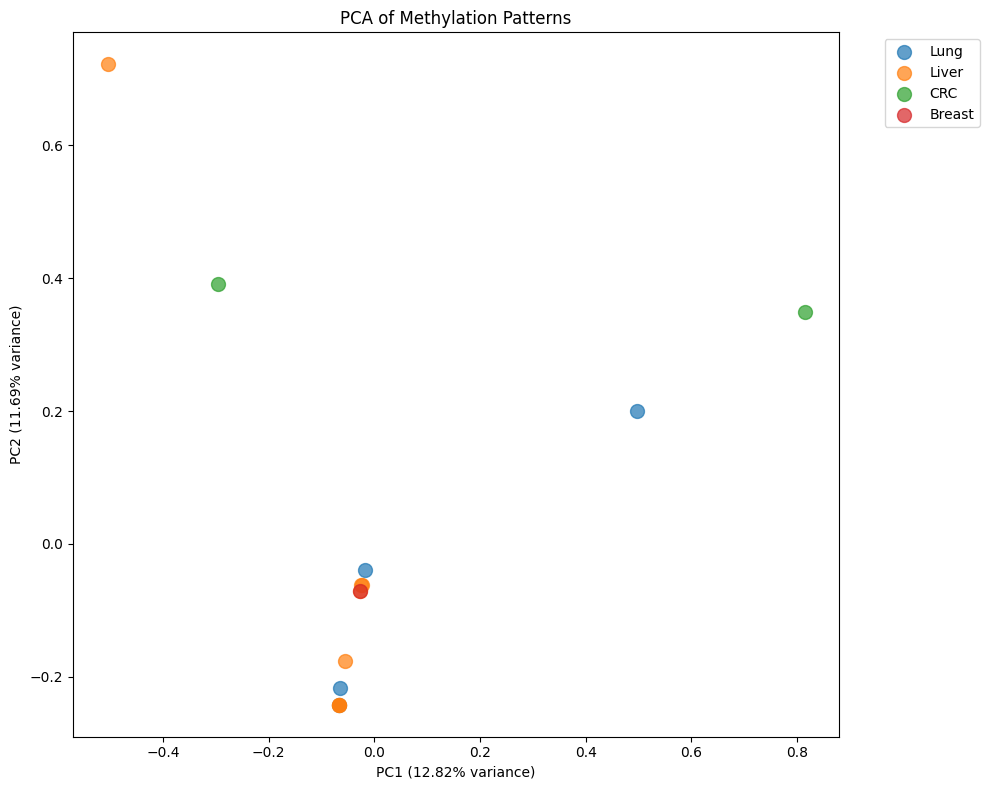

In [7]:
from sklearn.decomposition import PCA

# First, we need to extract sample metadata from df
# Get unique sample information (SampleID and TYPE)
metadata = df[['SampleID', 'TYPE']].drop_duplicates().set_index('SampleID')

# Perform PCA

# Transpose dfcount_wide so samples are rows
dfcount_wide_T = dfcount_wide.T

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dfcount_wide_T)

# Create a dataframe with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=dfcount_wide_T.index)

# Add TYPE information from metadata
pca_df['TYPE'] = pca_df.index.map(metadata['TYPE'])

# Plot PCA
plt.figure(figsize=(10, 8))
for tissue_type in pca_df['TYPE'].unique():
    subset = pca_df[pca_df['TYPE'] == tissue_type]
    plt.scatter(subset['PC1'], subset['PC2'], label=tissue_type, s=100, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of Methylation Patterns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

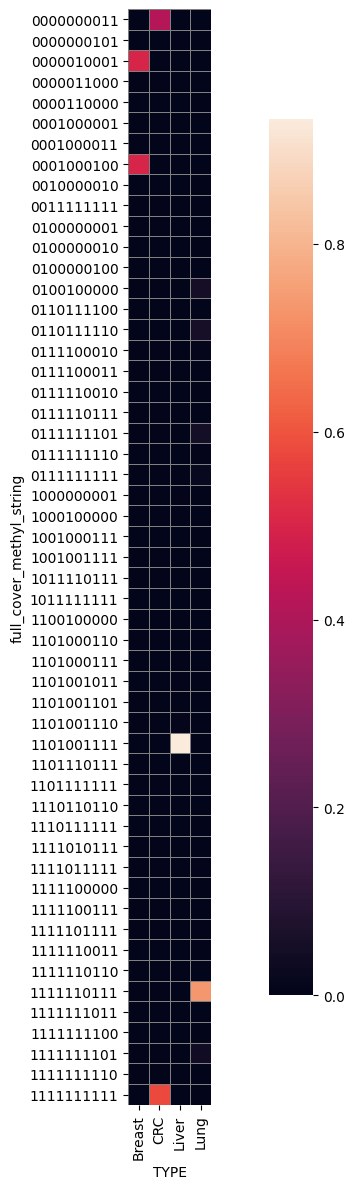

In [39]:
toodf = df_nowbc.groupby(["TYPE", "full_cover_methyl_string"])["SampleID"].count().reset_index().\
    pivot(index='full_cover_methyl_string', columns='TYPE', values='SampleID').fillna(0)
for c in toodf.columns:
    toodf[c] = toodf[c]/toodf[c].sum()

toodf = toodf[(toodf != 0).any(axis=1)]
plt.figure(figsize=(12, 12))
sns.heatmap(toodf, square=True, linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.8})
plt.tight_layout()
plt.show()

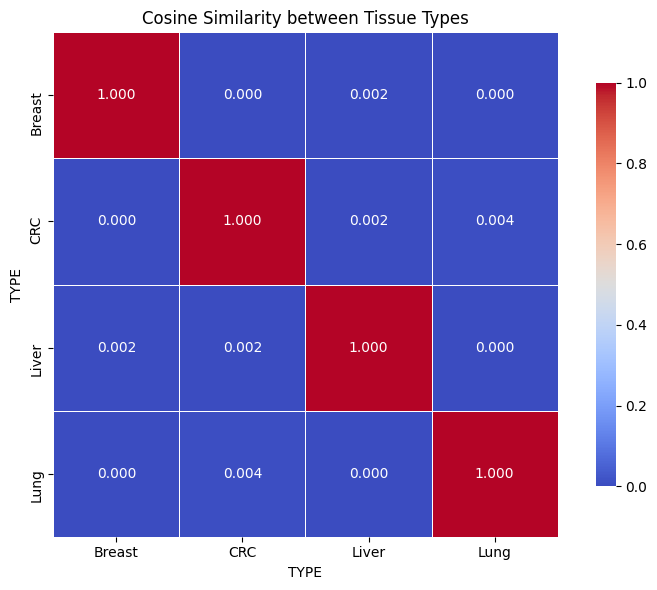

TYPE,Breast,CRC,Liver,Lung
TYPE,,,,
Breast,1.000000,0.000000,0.002104,0.000000
CRC,0.000000,1.000000,0.001735,0.004165
Liver,0.002104,0.001735,1.000000,0.000000
Lung,0.000000,0.004165,0.000000,1.000000


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between all columns of toodf
cosine_sim = cosine_similarity(toodf.T)

# Create a DataFrame with proper labels
cosine_sim_df = pd.DataFrame(cosine_sim, 
                              index=toodf.columns, 
                              columns=toodf.columns)

# Visualize the cosine similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_df, annot=True, fmt='.3f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Cosine Similarity between Tissue Types')
plt.tight_layout()
plt.show()

cosine_sim_df

0.01600866260861511